In [1]:
import os
import pickle
import functools
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from scipy import integrate
import pandas as pd

import jax
import jax.numpy as jnp
from jax.scipy import stats
from jax.scipy import special
from jax.config import config
config.update("jax_enable_x64", True) 
config.update('jax_platform_name', 'cpu')

In [2]:
plt.style.use("default")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
downstream_posteriors_dirname = "../../../results/toy-data/downstream-posteriors/"
dp_glm_posteriors_dirname = "../../../results/toy-data/dp-glm-posteriors/"
real_data_results_dirname = "../../../results/toy-data/real-data-results/"
figdir = "../../../figures/toy-data/"


epsilon = 1.0
repeat = 8

filename = downstream_posteriors_dirname + "{}_{}.p".format(repeat, epsilon)
with open(filename, "rb") as file:
    posterior_obj = pickle.load(file)

filename = real_data_results_dirname + "{}.p".format(repeat)
with open(filename, "rb") as file:
    real_data_obj = pickle.load(file)

# filename = dp_glm_posteriors_dirname + "{}_{}.p".format(repeat, epsilon)
# with open(filename, "rb") as file:
#     dp_glm_obj = pickle.load(file)

marginalised_laplace_approxes = posterior_obj["marginalised_laplace_approxes"]
s_posteriors = posterior_obj["s_posteriors"]

true_params = np.array(real_data_obj["true_params"])
nondp_post = real_data_obj["nondp_post"]

# dp_glm_inf_data = dp_glm_obj["dp_glm_inf_data"]
# dp_glm_posterior = dp_glm_inf_data.posterior.stack(draws=("chain", "draw"))
# dp_glm_posterior = dp_glm_posterior.theta_DP_scaled.values.transpose()

In [4]:
syn_data_name = "Syn. data $\\bar{p}_n(Q)$"
s_posterior_name = "Syn. data $p(X | \\tilde{s})$"

In [5]:
@jax.jit
def laplace_approx_mix_pdf(xs, laplace_approxes, i):
    means, covs = laplace_approxes

    if len(means.shape) == 1:
        return stats.norm.pdf(xs, loc=means[i], scale=jnp.sqrt(covs[i, i]))

    variances = covs.diagonal(axis1=1, axis2=2)
    ys = jax.vmap(
        lambda mean, var: stats.norm.pdf(xs, loc=mean, scale=var**0.5),
        (0, 0), 0
    )(means[:, i], variances[:, i])
    return ys.mean(axis=0)

@jax.jit 
def laplace_approx_mix_pdf_joint(xs, laplace_approxes):
    means, covs = laplace_approxes
    ys = jax.vmap(
        lambda mean, cov: stats.multivariate_normal.pdf(xs, mean, cov),
        (0, 0), 0
    )(means, covs)
    return ys.mean(axis=0)

@jax.jit 
def laplace_approx_mix_log_pdf_joint(xs, laplace_approxes):
    means, covs = laplace_approxes
    ys = jax.vmap(
        lambda mean, cov: stats.multivariate_normal.logpdf(xs, mean, cov),
        (0, 0), 0
    )(means, covs)
    return special.logsumexp(ys, axis=0, b=1 / ys.shape[0])

def sample_laplace_approx(rng, size, laplace_approxes):
    means, covs = laplace_approxes
    d = means[0].shape[0]
    rng, ind_key = jax.random.split(rng)
    rng, sample_key = jax.random.split(rng, 2)
    inds = jax.random.choice(ind_key, len(means), (size,), replace=True)
    sample_means = means[inds]
    sample_covs = covs[inds]
    samples = jax.random.multivariate_normal(sample_key, sample_means, sample_covs)
    return samples


In [6]:
n_syn_datasets = 400
n_syn_dataset_mul = 20

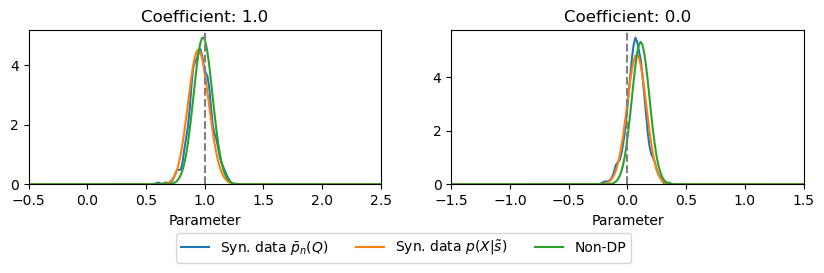

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 2))
for i in range(2):
    ax = axes[i]
    xlim = np.array((-1.5, 1.5)) + true_params[i]
    ax.set_xlim(xlim)
    xs = np.linspace(*xlim, 200)

    laplace_approx = marginalised_laplace_approxes[n_syn_datasets, n_syn_dataset_mul]
    ax.plot(xs, laplace_approx_mix_pdf(xs, laplace_approx, i), label=syn_data_name)

    ax.plot(xs, laplace_approx_mix_pdf(xs, s_posteriors, i), label=s_posterior_name)

    ax.plot(xs, laplace_approx_mix_pdf(xs, nondp_post, i), label="Non-DP")

    # sns.kdeplot(dp_glm_posterior[:, i], ax=ax, label="DP-GLM")

    ax.axvline(true_params[i], color="grey", linestyle="dashed")
    
    ax.set_title("Coefficient: {}".format(true_params[i]))
    ymin, ymax = ax.get_ylim()
    ax.set_ylim((0, ymax))
    ax.set_xlabel("Parameter")

leg_h, leg_l = axes[0].get_legend_handles_labels()
# plt.tight_layout()
fig.legend(leg_h, leg_l, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.savefig(figdir + "toy_data_results_eps_{}.pdf".format(epsilon), bbox_inches="tight")
plt.show()

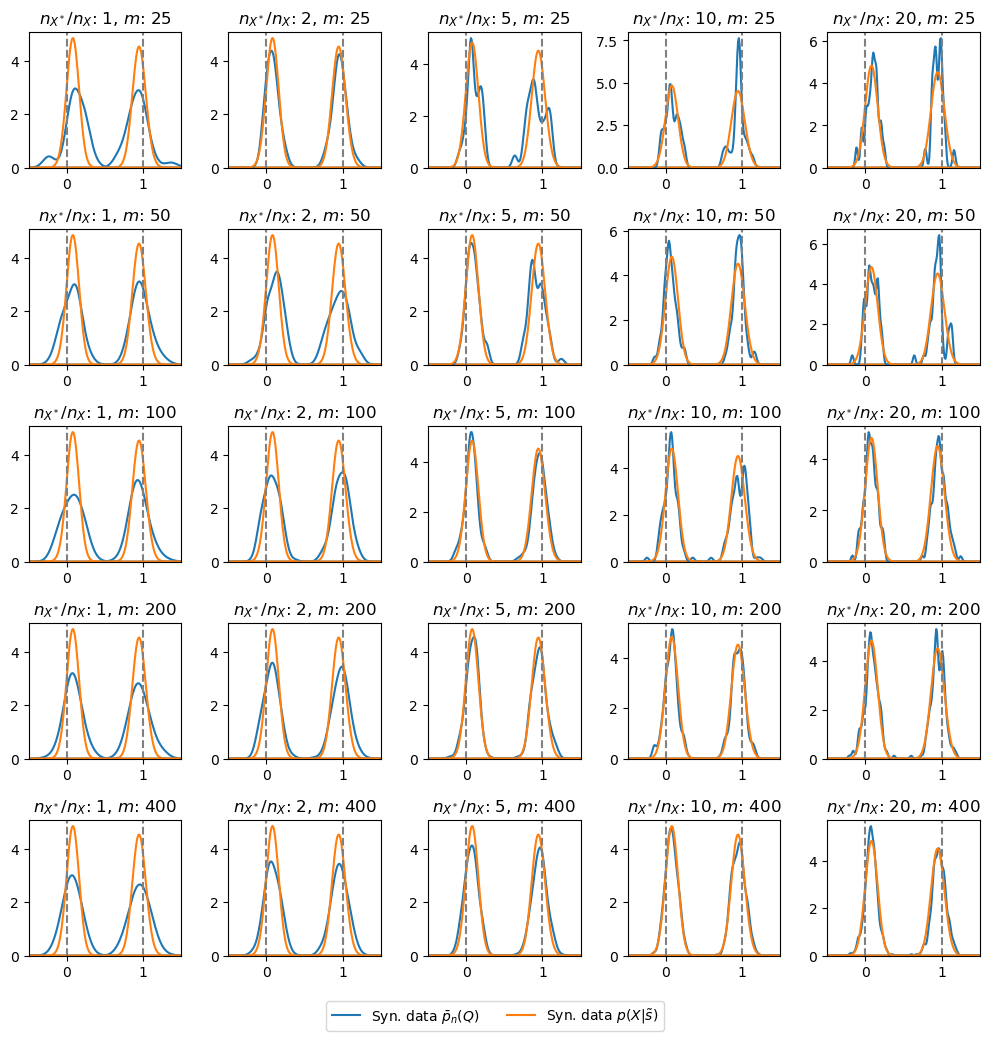

In [8]:
n_syn_datasets_vals = [25, 50, 100, 200, 400]
n_syn_dataset_mul_vals = [1, 2, 5, 10, 20]

fig, axes = plt.subplots(
    len(n_syn_datasets_vals), len(n_syn_dataset_mul_vals), 
    figsize=(2 * len(n_syn_dataset_mul_vals), 2 * len(n_syn_datasets_vals))
)
for i, n_syn_datasets_val in enumerate(n_syn_datasets_vals):
    for j, n_syn_dataset_mul_val in enumerate(n_syn_dataset_mul_vals):
        for k in range(2):
            ax = axes[i, j]
            xlim = (-0.5, 1.5)
            ax.set_xlim(xlim)
            xs = np.linspace(*xlim, 200)

            laplace_approx = marginalised_laplace_approxes[n_syn_datasets_val, n_syn_dataset_mul_val]
            label = syn_data_name if k == 0 else None
            ax.plot(xs, laplace_approx_mix_pdf(xs, laplace_approx, k), label=label, color="C0")

            label = s_posterior_name if k == 0 else None
            ax.plot(xs, laplace_approx_mix_pdf(xs, s_posteriors, k), label=label, color="C1")

            ax.axvline(true_params[k], color="grey", linestyle="dashed")

        ax.set_title("$n_{{X^*}} / n_X$: {}, $m$: {}".format(n_syn_dataset_mul_val, n_syn_datasets_val))
        ymin, ymax = ax.get_ylim()
        ax.set_ylim((0, ymax))

leg_h, leg_l = axes[0, 0].get_legend_handles_labels()
plt.tight_layout()
fig.legend(leg_h, leg_l, loc="upper center", bbox_to_anchor=(0.5, -0.00), ncol=2)
plt.savefig(figdir + "hyperparameter_comparison.pdf", bbox_inches="tight")
plt.show()

In [ ]:
def total_variation_distance_record(obj, dim, n_syn_datasets, n_syn_dataset_mul, tvd, tvd_error):
    return {
        "epsilon": obj["epsilon"],
        "delta": obj["delta"],
        "repeat": obj["repeat"],
        "total_variation_distance": tvd,
        "total_variation_distance_error": tvd_error,
        "dim": dim,
        "n_syn_datasets": n_syn_datasets,
        "n_syn_dataset_mul": n_syn_dataset_mul,
    }

all_records = []
for path in Path(downstream_posteriors_dirname).glob("*.p"):
    with open(path, "rb") as file:
        obj = pickle.load(file)
    all_marginalised_posteriors = obj["marginalised_laplace_approxes"]
    s_posteriors = obj["s_posteriors"]

    for i, n_syn_datasets_val in enumerate(n_syn_datasets_vals):
        for j, n_syn_dataset_mul_val in enumerate(n_syn_dataset_mul_vals):
            marginalised_posteriors = all_marginalised_posteriors[n_syn_datasets_val, n_syn_dataset_mul_val]
            for k in range(2):
                total_variation_distance, error = integrate.quad(
                    lambda x: np.abs(
                        laplace_approx_mix_pdf(x, marginalised_posteriors, k) 
                        - laplace_approx_mix_pdf(x, s_posteriors, k) 
                    ), 
                    -np.inf, np.inf, limit=200
                )
                total_variation_distance *= 0.5
                all_records.append(total_variation_distance_record(
                    obj, k, n_syn_datasets_val, n_syn_dataset_mul_val,
                    total_variation_distance, error,
                ))

tvd_df = pd.DataFrame.from_records(all_records)

In [ ]:
tvd_df.to_csv("../../../results/toy-data/tvd-table.csv", index=False)
# tvd_df = pd.read_csv("../../../results/toy-data/tvd-table.csv", index_col=False)
tvd_df

,epsilon,delta,repeat,total_variation_distance,total_variation_distance_error,dim,n_syn_datasets,n_syn_dataset_mul
0,0.1,2.500000e-07,42,0.223675,1.340928e-08,0,25,1
1,0.1,2.500000e-07,42,0.242136,3.581156e-09,1,25,1
2,0.1,2.500000e-07,42,0.236582,1.312717e-08,0,25,2
3,0.1,2.500000e-07,42,0.224262,7.531840e-09,1,25,2
4,0.1,2.500000e-07,42,0.297016,1.352116e-08,0,25,5
...,...,...,...,...,...,...,...,...
14995,1.0,2.500000e-07,62,0.094659,1.218153e-08,1,400,5
14996,1.0,2.500000e-07,62,0.053650,2.972540e-09,0,400,10
14997,1.0,2.500000e-07,62,0.064064,1.057613e-08,1,400,10
14998,1.0,2.500000e-07,62,0.057315,6.574167e-09,0,400,20


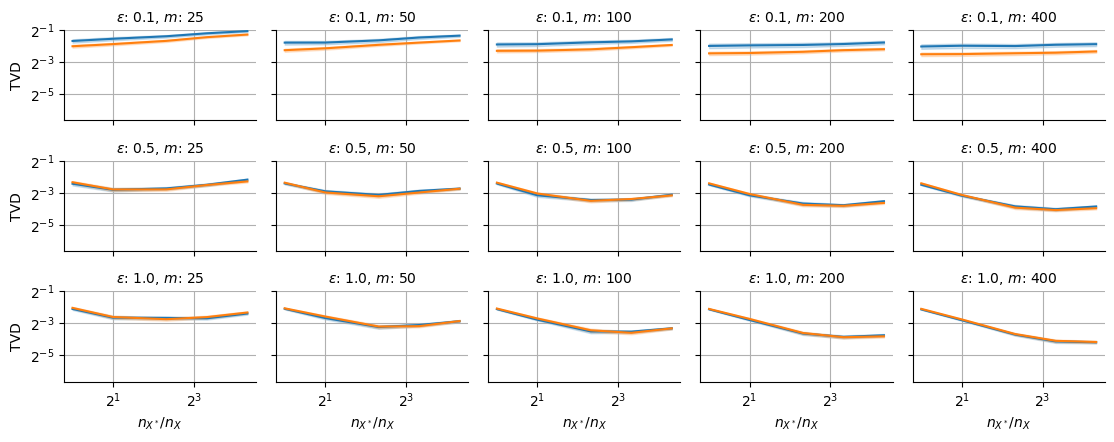

In [ ]:
cdf = tvd_df.copy()
g = sns.FacetGrid(cdf, col="n_syn_datasets", row="epsilon", hue="dim", ylim=(0.01, 0.5), height=1.5, aspect=1.5)
g.map_dataframe(sns.lineplot, x="n_syn_dataset_mul", y="total_variation_distance")
g.set_titles(template="$\epsilon$: {row_name}, $m$: {col_name}")
g.map(lambda **kws: plt.gca().set_xscale("log", base=2))
g.map(lambda **kws: plt.gca().set_yscale("log", base=2))
g.map(lambda **kws: plt.gca().grid(True))
g.set_xlabels("$n_{{X^*}} / n_X$")
g.set_ylabels("TVD")
plt.savefig(figdir + "hyperparameter_comparison_tvd.pdf")
plt.show()

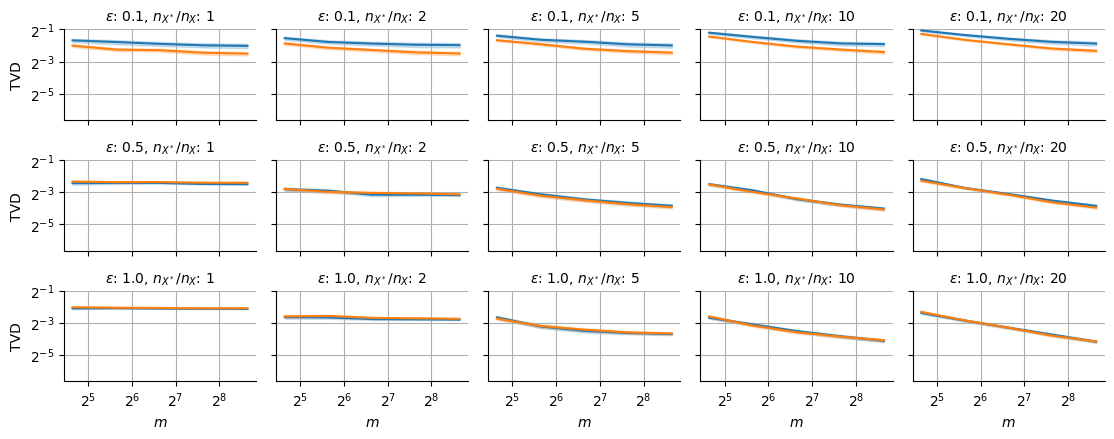

In [ ]:
cdf = tvd_df.copy()
g = sns.FacetGrid(cdf, col="n_syn_dataset_mul", row="epsilon", hue="dim", ylim=(0.01, 0.5), height=1.5, aspect=1.5)
g.map_dataframe(sns.lineplot, x="n_syn_datasets", y="total_variation_distance")
g.set_titles(template="$\epsilon$: {row_name}, $n_{{X^*}} / n_X$: {col_name}")
g.map(lambda **kws: plt.gca().set_xscale("log", base=2))
g.map(lambda **kws: plt.gca().set_yscale("log", base=2))
g.map(lambda **kws: plt.gca().grid(True))
g.set_xlabels("$m$")
g.set_ylabels("TVD")
plt.savefig(figdir + "hyperparameter_comparison_tvd_transpose.pdf")
plt.show()

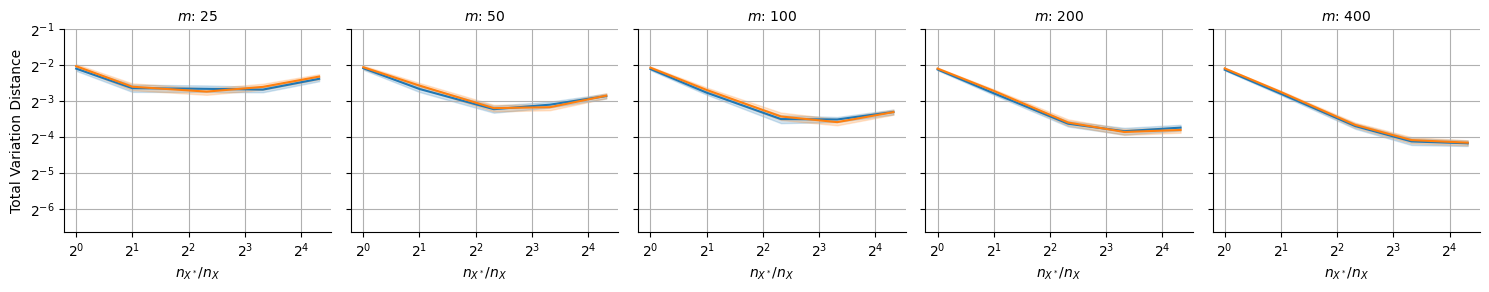

In [ ]:
cdf = tvd_df.copy()
cdf = tvd_df[tvd_df.epsilon == 1.0]
g = sns.FacetGrid(cdf, col="n_syn_datasets", hue="dim", ylim=(0.01, 0.5))
g.map_dataframe(sns.lineplot, x="n_syn_dataset_mul", y="total_variation_distance")
g.map(lambda **kws: plt.gca().set_xscale("log", base=2))
g.map(lambda **kws: plt.gca().set_yscale("log", base=2))
g.map(lambda **kws: plt.gca().grid(True))
g.set_titles(template="$m$: {col_name}")
g.set_xlabels("$n_{{X^*}} / n_X$")
g.set_ylabels("Total Variation Distance")
plt.savefig(figdir + "hyperparameter_comparison_tvd_eps_1.pdf")
plt.show()

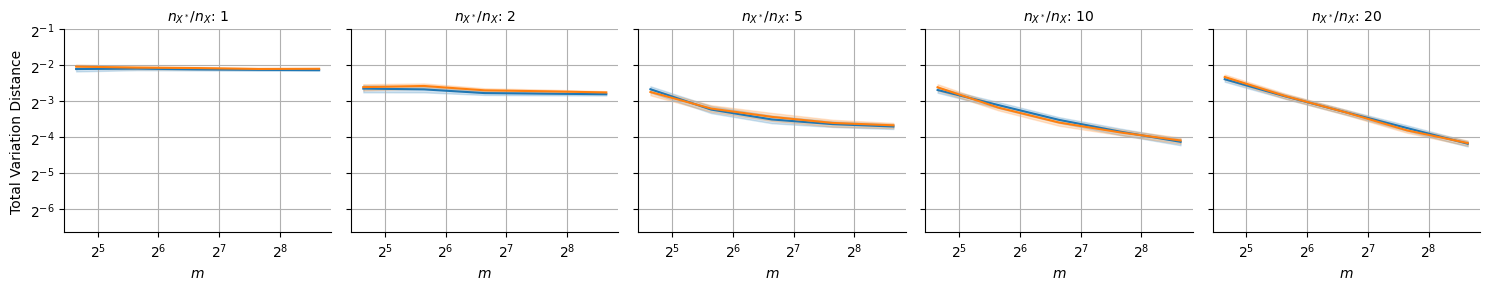

In [ ]:
cdf = tvd_df.copy()
cdf = tvd_df[tvd_df.epsilon == 1.0]
g = sns.FacetGrid(cdf, col="n_syn_dataset_mul", row="epsilon", hue="dim", ylim=(0.01, 0.5))
g.map_dataframe(sns.lineplot, x="n_syn_datasets", y="total_variation_distance")
g.map(lambda **kws: plt.gca().set_xscale("log", base=2))
g.map(lambda **kws: plt.gca().set_yscale("log", base=2))
g.map(lambda **kws: plt.gca().grid(True))
g.set_titles(template="$n_{{X^*}} / n_X$: {col_name}")
g.set_xlabels("$m$")
g.set_ylabels("Total Variation Distance")
plt.savefig(figdir + "hyperparameter_comparison_tvd_eps_1_transpose.pdf")
plt.show()

In [14]:
@jax.jit
def monte_carlo_posterior_intervals(rng, laplace_approximations, conf_levels, mc_samples=1000):
    samples = sample_laplace_approx(rng, mc_samples, laplace_approximations)
    lbs = (1 - conf_levels) / 2
    ubs = 1 - lbs
    bounds = jnp.stack((lbs, ubs), axis=1)
    quantiles = jax.vmap(
        lambda bounds: jnp.quantile(samples, bounds, axis=0)
        , 0, 0
    )(bounds) # (conf_level, lower/upper, dimension)
    return quantiles

@jax.jit
def has_coverage_width(rng, laplace_approximations, conf_levels, true_params, mc_samples=1000):
    intervals = monte_carlo_posterior_intervals(rng, laplace_approximations, conf_levels)
    has_coverage = (intervals[:, 0, :] <= true_params) & (intervals[:, 1, :] >= true_params).astype(int)
    width = intervals[:, 1, :] - intervals[:, 0, :]
    return has_coverage, width


In [15]:


conf_levels = jnp.linspace(0.05, 0.95, 19)
rng = jax.random.PRNGKey(4628368)
all_records = []
def conf_int_record(obj, conf_level, type, width, coverage, dim):
    return {
        "epsilon": obj["epsilon"],
        "delta": obj["delta"],
        "repeat": obj["repeat"],
        "width": float(width),
        "has_coverage": int(coverage),
        "dim": dim,
        "conf_level": float(conf_level),
        "type": type,
    }

for path in Path(downstream_posteriors_dirname).glob("*.p"):
    with open(path, "rb") as file:
        obj = pickle.load(file)
    marginalised_posteriors = obj["marginalised_laplace_approxes"][n_syn_datasets, n_syn_dataset_mul]
    s_posteriors = obj["s_posteriors"]

    rng, key = jax.random.split(rng)
    marginalised_coverage, marginalised_width = has_coverage_width(key, marginalised_posteriors, conf_levels, true_params)
    rng, key = jax.random.split(rng)
    s_coverage, s_width = has_coverage_width(key, s_posteriors, conf_levels, true_params)

    for j, (coverage, width) in enumerate(zip(marginalised_coverage, marginalised_width)):
        for i in range(2):
            all_records.append(conf_int_record(obj, conf_levels[j], syn_data_name, width[i], coverage[i], i))
    for j, (coverage, width) in enumerate(zip(s_coverage, s_width)):
        for i in range(2):
            all_records.append(conf_int_record(obj, conf_levels[j], s_posterior_name, width[i], coverage[i], i))


for path in Path(dp_glm_posteriors_dirname).glob("*.p"):
    with open(path, "rb") as file:
        obj = pickle.load(file)
    dp_glm_inf_data = obj["dp_glm_inf_data"]
    dp_glm_posterior = dp_glm_inf_data.posterior.stack(draws=("chain", "draw"))
    dp_glm_posterior = dp_glm_posterior.theta_DP_scaled.values.transpose()

    for conf_level in conf_levels:
        lb = (1 - conf_level) / 2
        ub = 1 - lb
        interval = np.quantile(dp_glm_posterior, [lb, ub], axis=0)
        coverage = ((interval[0, :] <= true_params) & (interval[1, :] >= true_params)).astype(int)
        width = interval[1, :] - interval[0, :]

        for i in range(2):
            all_records.append(conf_int_record(obj, conf_level, "DP-GLM", width[i], coverage[i], i))

df = pd.DataFrame.from_records(all_records)
df["coefficient"] = true_params[df.dim]

In [16]:
df

,epsilon,delta,repeat,width,has_coverage,dim,conf_level,type,coefficient
0,0.1,2.500000e-07,42,0.044289,1,0,0.05,Syn. data $\bar{p}_n(Q)$,1.0
1,0.1,2.500000e-07,42,0.054116,0,1,0.05,Syn. data $\bar{p}_n(Q)$,0.0
2,0.1,2.500000e-07,42,0.120071,1,0,0.10,Syn. data $\bar{p}_n(Q)$,1.0
3,0.1,2.500000e-07,42,0.101510,0,1,0.10,Syn. data $\bar{p}_n(Q)$,0.0
4,0.1,2.500000e-07,42,0.202752,1,0,0.15,Syn. data $\bar{p}_n(Q)$,1.0
...,...,...,...,...,...,...,...,...,...
34195,1.0,2.500000e-07,62,0.356292,1,1,0.85,DP-GLM,0.0
34196,1.0,2.500000e-07,62,1.068939,0,0,0.90,DP-GLM,1.0
34197,1.0,2.500000e-07,62,0.407393,1,1,0.90,DP-GLM,0.0
34198,1.0,2.500000e-07,62,1.149577,0,0,0.95,DP-GLM,1.0


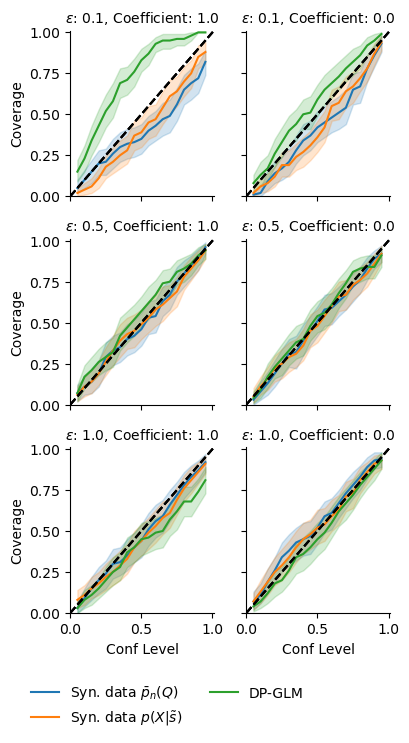

In [17]:
cdf = df.copy()
g = sns.FacetGrid(cdf, row="epsilon", col="coefficient", hue="type", col_order=true_params, xlim=(0, 1.01), ylim=(0, 1.01), height=2.25, aspect=1)
g.map_dataframe(sns.lineplot, x="conf_level", y="has_coverage")
diag = (0.0, 1.01)
g.map(lambda **kws: plt.gca().plot(diag, diag, linestyle="dashed", color="black"))
g.add_legend(title="", loc="upper center", bbox_to_anchor=(0.3, -0.00), ncol=2)
g.set_titles(template="$\epsilon$: {row_name}, Coefficient: {col_name}")
g.set_xlabels("Conf Level")
g.set_ylabels("Coverage")
plt.savefig(figdir + "coverages.pdf", bbox_inches="tight")
plt.show()

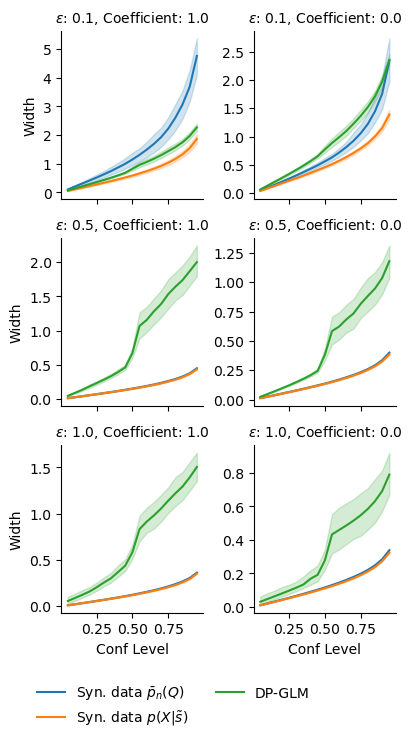

In [18]:
g = sns.FacetGrid(cdf, row="epsilon", col="coefficient", hue="type", col_order=true_params, sharey=False, height=2.25, aspect=1)
g.map_dataframe(sns.lineplot, x="conf_level", y="width")
g.add_legend(title="", loc="upper center", bbox_to_anchor=(0.3, -0.00), ncol=2)
g.set_titles(template="$\epsilon$: {row_name}, Coefficient: {col_name}")
g.set_xlabels("Conf Level")
g.set_ylabels("Width")
plt.savefig(figdir + "widths.pdf", bbox_inches="tight")
plt.show()